### Importing required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import sqrt 
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
# load train dataset
train = pd.read_csv('DS_DF_WQI_Train.csv')
train.head()

,SMPLDATETIME,STNCODE,USRCODES,Temp,SpCond,Sal,DO_pct,DO_mgl,Depth,pH,Turb,WQI,WQI_Class
0,2004-01-01 00:00:00,deldswq,00:00:00,5.2,0.13,0.1,101.9,12.9,0.45,6.6,0.012,12.639779,Excellent
1,2004-01-01 00:30:00,deldswq,00:30:00,5.2,0.12,0.1,101.8,12.9,0.45,6.6,0.013,12.636899,Excellent
2,2004-01-01 01:00:00,deldswq,01:00:00,5.2,0.12,0.1,101.8,12.9,0.45,6.6,0.012,12.631159,Excellent
3,2004-01-01 01:30:00,deldswq,01:30:00,5.1,0.13,0.1,101.8,13.0,0.46,6.6,0.013,12.349211,Excellent
4,2004-01-01 02:00:00,deldswq,02:00:00,5.1,0.13,0.1,101.8,13.0,0.46,6.6,0.012,12.343470,Excellent


In [4]:
# load test dataset
test = pd.read_csv('DS_DF_WQI_Test.csv')
test.head()

,SMPLDATETIME,STNCODE,USRCODES,Temp,SpCond,Sal,DO_pct,DO_mgl,Depth,pH,Turb,WQI,WQI_Class
0,2006-02-25 01:00:00,deldswq,01:00:00,4.4,0.2,0.1,97.5,12.7,0.46,7.1,0.009,9.620504,Excellent
1,2006-02-25 01:30:00,deldswq,01:30:00,4.3,0.2,0.1,97.5,12.7,0.46,7.1,0.009,9.604559,Excellent
2,2006-02-25 02:00:00,deldswq,02:00:00,4.3,0.2,0.1,97.3,12.7,0.45,7.1,0.009,9.600074,Excellent
3,2006-02-25 02:30:00,deldswq,02:30:00,4.3,0.2,0.1,97.2,12.6,0.45,7.1,0.009,9.875953,Excellent
4,2006-02-25 03:00:00,deldswq,03:00:00,4.3,0.2,0.1,97.1,12.6,0.45,7.1,0.009,9.873710,Excellent


### Removing un wanted columns and setting the date column as index

In [5]:
train['SMPLDATETIME'] = pd.to_datetime(train.SMPLDATETIME , format = '%Y-%m-%d %H:%M:%S')
data = train.drop(['SMPLDATETIME','STNCODE','USRCODES'], axis=1)
data.index = train.SMPLDATETIME
data.head()

,Temp,SpCond,Sal,DO_pct,DO_mgl,Depth,pH,Turb,WQI,WQI_Class
SMPLDATETIME,,,,,,,,,,
2004-01-01 00:00:00,5.2,0.13,0.1,101.9,12.9,0.45,6.6,0.012,12.639779,Excellent
2004-01-01 00:30:00,5.2,0.12,0.1,101.8,12.9,0.45,6.6,0.013,12.636899,Excellent
2004-01-01 01:00:00,5.2,0.12,0.1,101.8,12.9,0.45,6.6,0.012,12.631159,Excellent
2004-01-01 01:30:00,5.1,0.13,0.1,101.8,13.0,0.46,6.6,0.013,12.349211,Excellent
2004-01-01 02:00:00,5.1,0.13,0.1,101.8,13.0,0.46,6.6,0.012,12.343470,Excellent


In [6]:
data.shape

(33138, 10)

In [7]:
data.describe()

,Temp,SpCond,Sal,DO_pct,DO_mgl,Depth,pH,Turb,WQI
count,33138.000000,33138.000000,33138.000000,33138.000000,33138.000000,33138.000000,33138.000000,33138.000000,33138.000000
mean,16.416166,0.170768,0.100368,84.594402,8.719715,0.297306,6.896084,0.017879,24.446340
std,8.516762,0.038114,0.016180,23.269814,3.181803,0.151005,0.388328,0.070703,10.695210
min,0.900000,0.010000,0.000000,2.800000,0.200000,-0.130000,5.500000,0.003000,5.695915
25%,8.400000,0.150000,0.100000,76.500000,6.500000,0.200000,6.700000,0.008000,15.507938
50%,16.500000,0.170000,0.100000,92.000000,9.200000,0.280000,6.900000,0.010000,23.425735
75%,24.700000,0.180000,0.100000,98.200000,11.400000,0.380000,7.100000,0.014000,32.214438
max,32.700000,0.610000,0.300000,157.200000,14.800000,1.300000,9.600000,2.531000,63.059231


In [8]:
# checking for null values
data.isnull().sum()

Temp         0
SpCond       0
Sal          0
DO_pct       0
DO_mgl       0
Depth        0
pH           0
Turb         0
WQI          0
WQI_Class    0
dtype: int64

In [9]:
#remove WQI_Class as we are concentrating on time series
data1= data.drop([ 'WQI_Class'], axis=1)

### Visualization of all columns

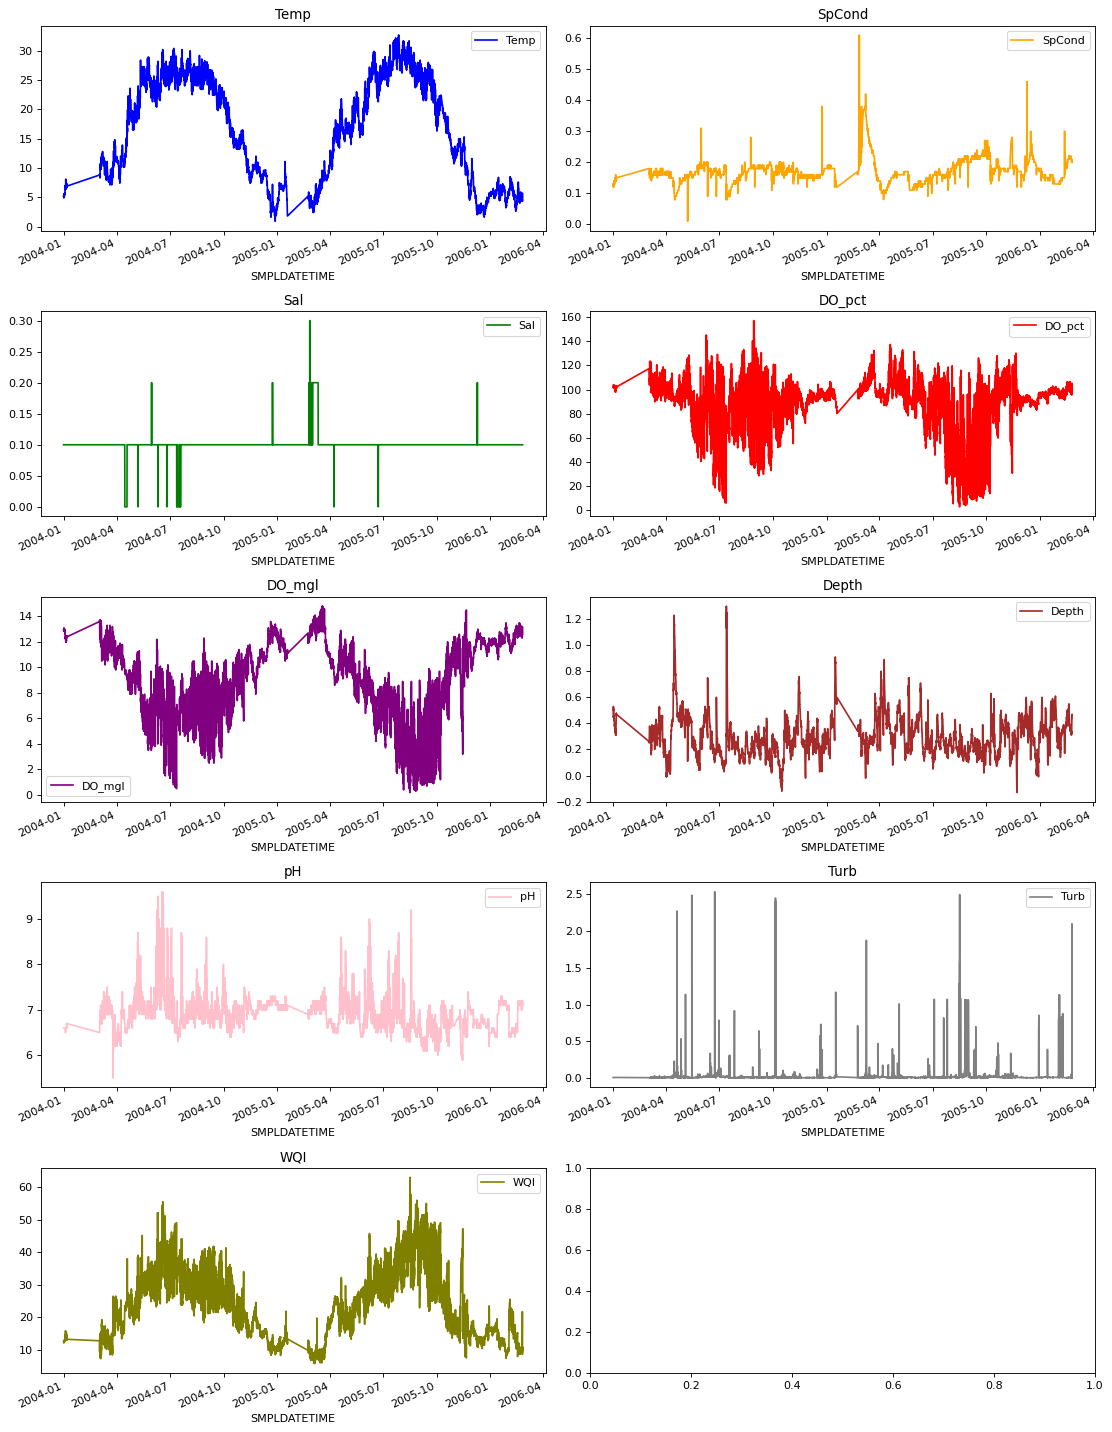

In [10]:
color_list = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
]


def Visualize(data):
    features= list(data1.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)
    fig, axes = plt.subplots(
        nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(feature_size):
        key = features[i]
        c = color_list[i % (len(color_list))]
        t_data = data[key]
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(key),
            rot=25,
        )
        ax.legend([key])
    plt.tight_layout()


Visualize(data1)

### Checking for stationarity by Dickey- fuller test
#### Null Hypothesis  -  Series is Stationary
#### Alternative Hypothesis  -  Series is not Stationary

In [11]:
for i in range(len(data1.columns)):
    result = adfuller(data1[data1.columns[i]])
    
    if result[1] > 0.05 :
        print('{} - Series is not Stationary'.format(data1.columns[i]))
    else:
        print('{} - Series is Stationary'.format(data1.columns[i]))

Temp - Series is not Stationary
SpCond - Series is Stationary
Sal - Series is Stationary
DO_pct - Series is Stationary
DO_mgl - Series is Stationary
Depth - Series is Stationary
pH - Series is Stationary
Turb - Series is Stationary
WQI - Series is Stationary


As the Temp column is not stationary i did first order differencing to make it Stationary

In [12]:
data1['Temp']=data1['Temp'].diff()[1:]
data1['Temp'] = data1['Temp'].fillna(0)

In [13]:
# Again checking for stationarity
for i in range(len(data1.columns)):
    result = adfuller(data1[data1.columns[i]])
    
    if result[1] > 0.05 :
        print('{} - Series is not Stationary'.format(data1.columns[i]))
    else:
        print('{} - Series is Stationary'.format(data1.columns[i]))

Temp - Series is Stationary
SpCond - Series is Stationary
Sal - Series is Stationary
DO_pct - Series is Stationary
DO_mgl - Series is Stationary
Depth - Series is Stationary
pH - Series is Stationary
Turb - Series is Stationary
WQI - Series is Stationary


### Applying grangercausality tests 
Granger causality is an econometric test used to verify the usefulness of one variable to forecast another

In [14]:
# Considering Target as WQI and checking for 4 lags
max_lags=4
y='WQI'

In [16]:
for i in range(len(data1.columns)-1):
    results=grangercausalitytests(data1[[y,data1.columns[i-9]]], max_lags, verbose=False)
    p_values=[round(results[i+1][0]['ssr_ftest'][1],4) for i in range(max_lags)]
    print('Column - {} : P_Values - {}'.format(data1.columns[i-9],p_values))

Column - Temp : P_Values - [0.0, 0.0, 0.0, 0.0]
Column - SpCond : P_Values - [0.3148, 0.0079, 0.0007, 0.0]
Column - Sal : P_Values - [0.0241, 0.0145, 0.0007, 0.0008]
Column - DO_pct : P_Values - [0.0, 0.0, 0.0, 0.0]
Column - DO_mgl : P_Values - [0.4169, 0.0, 0.0, 0.0]
Column - Depth : P_Values - [0.0, 0.0, 0.0, 0.0]
Column - pH : P_Values - [0.0, 0.0, 0.0, 0.0]
Column - Turb : P_Values - [0.0, 0.0, 0.0, 0.0]


#### we observed that 'Temp','DO_pct','Depth','pH','Turb' are important to forecast WQI 

In [15]:
for i in range(len(data1.columns)-1):
    print(data1.columns[i-9])

Temp
SpCond
Sal
DO_pct
DO_mgl
Depth
pH
Turb


In [17]:
train_df = data[['WQI','Temp','DO_pct','Depth','pH','Turb']]
print(train_df.shape)

(33138, 6)


#### Using VAR model for forecasting

In [18]:
model = VAR(train_df)
model.select_order(20).summary()

,AIC,BIC,FPE,HQIC
0,1.276,1.278,3.584,1.277
1,-24.00,-23.99,3.771e-11,-24.00
2,-24.47,-24.45,2.352e-11,-24.47
3,-24.78,-24.75,1.725e-11,-24.77
4,-24.89,-24.85,1.554e-11,-24.88
5,-24.92,-24.87*,1.511e-11,-24.90
6,-24.92,-24.87,1.499e-11,-24.91
7,-24.93,-24.86,1.489e-11,-24.91
8,-24.94,-24.87,1.474e-11,-24.92
9,-24.95,-24.87,1.459e-11,-24.92


In [19]:
# selecting minimum lags 5 by above model select order and fitting the model
model = VAR(endog=train_df)
model_fit  = model.fit(5)
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 30, Apr, 2023
Time:                     09:48:30
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -24.8712
Nobs:                     33133.0    HQIC:                  -24.9033
Log likelihood:           130914.    FPE:                1.50688e-11
AIC:                     -24.9184    Det(Omega_mle):     1.49845e-11
--------------------------------------------------------------------
Results for equation WQI
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.792562         0.091552            8.657           0.000
L1.WQI            0.895169         0.007692          116.380           0.000
L1.Temp          -0.132934         0.040680           -3.268           0.001
L

In [20]:
# forecasting  the test data len(test data) is 14202
predictions = model_fit.forecast(model_fit.endog, steps=14202)

In [39]:
df_predicted = pd.DataFrame(predictions, columns = ['WQI_pred','Temp_pred','DO_pct_pred','Depth_pred','pH_pred','Turb_pred'])
df_predicted.index = test.SMPLDATETIME
df_predicted.head()

,WQI_pred,Temp_pred,DO_pct_pred,Depth_pred,pH_pred,Turb_pred
SMPLDATETIME,,,,,,
2006-02-25 01:00:00,9.866454,4.387761,97.576420,0.458804,7.097739,0.008614
2006-02-25 01:30:00,9.910440,4.382352,97.737699,0.457937,7.098595,0.011297
2006-02-25 02:00:00,9.901814,4.383532,97.971141,0.457181,7.099126,0.009875
2006-02-25 02:30:00,9.876820,4.387787,98.276158,0.456637,7.100191,0.010252
2006-02-25 03:00:00,9.836313,4.395572,98.662202,0.456116,7.101475,0.010706


#### Removing un wanted columns in test and setting the date column as index

In [22]:
test['SMPLDATETIME'] = pd.to_datetime(test.SMPLDATETIME , format = '%Y-%m-%d %H:%M:%S')
test_df = test[['WQI','Temp','DO_pct','Depth','pH','Turb']]
test_df.index = test.SMPLDATETIME
test_df.head()

,WQI,Temp,DO_pct,Depth,pH,Turb
SMPLDATETIME,,,,,,
2006-02-25 01:00:00,9.620504,4.4,97.5,0.46,7.1,0.009
2006-02-25 01:30:00,9.604559,4.3,97.5,0.46,7.1,0.009
2006-02-25 02:00:00,9.600074,4.3,97.3,0.45,7.1,0.009
2006-02-25 02:30:00,9.875953,4.3,97.2,0.45,7.1,0.009
2006-02-25 03:00:00,9.873710,4.3,97.1,0.45,7.1,0.009


#### Ploting the Orginal test values vs predictions

<AxesSubplot:xlabel='SMPLDATETIME'>

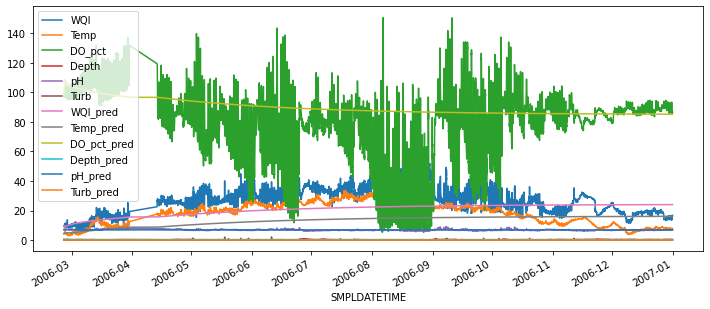

In [40]:
test_vs_pred=pd.concat([test_df,df_predicted],axis=1)
test_vs_pred.plot(figsize=(12,5))

#### As we see lot of mess in above plot i am ploting indivisualy

<AxesSubplot:xlabel='SMPLDATETIME'>

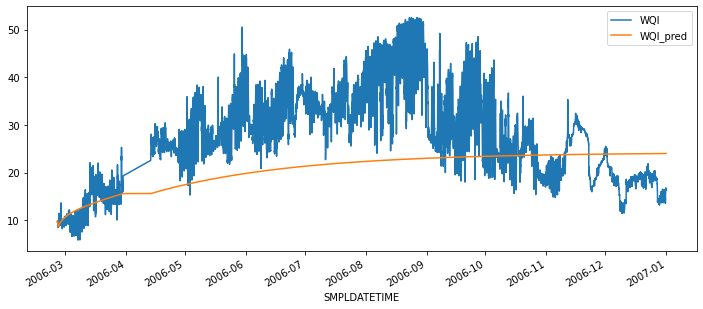

In [42]:
# for WQI column
test_vs_pred_WQI=pd.concat([test_df.WQI,df_predicted.WQI_pred],axis=1)
test_vs_pred_WQI.plot(figsize=(12,5))

<AxesSubplot:xlabel='SMPLDATETIME'>

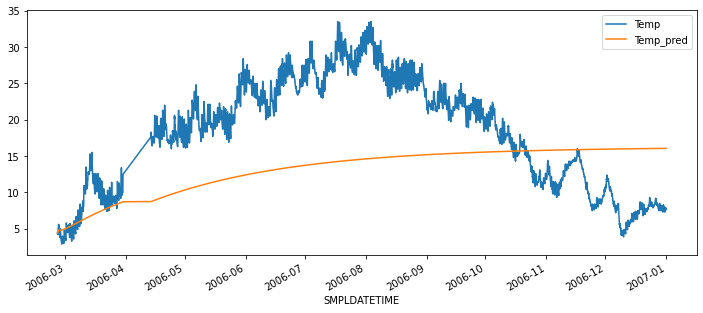

In [43]:
# for Temp column
test_vs_pred_Temp=pd.concat([test_df.Temp,df_predicted.Temp_pred],axis=1)
test_vs_pred_Temp.plot(figsize=(12,5))

<AxesSubplot:xlabel='SMPLDATETIME'>

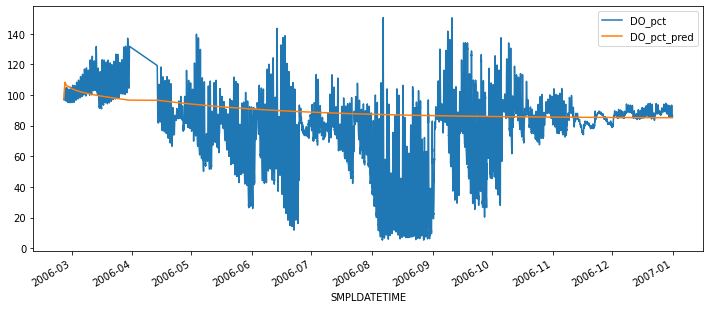

In [44]:
# for DO_pct column
test_vs_pred_DO_pct=pd.concat([test_df.DO_pct,df_predicted.DO_pct_pred],axis=1)
test_vs_pred_DO_pct.plot(figsize=(12,5))

<AxesSubplot:xlabel='SMPLDATETIME'>

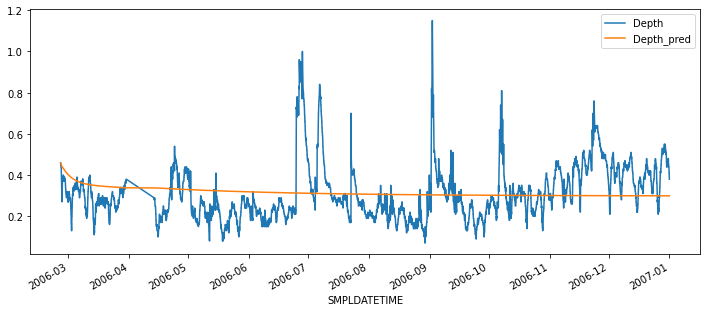

In [45]:
# for Depth column
test_vs_pred_Depth=pd.concat([test_df.Depth,df_predicted.Depth_pred],axis=1)
test_vs_pred_Depth.plot(figsize=(12,5))

<AxesSubplot:xlabel='SMPLDATETIME'>

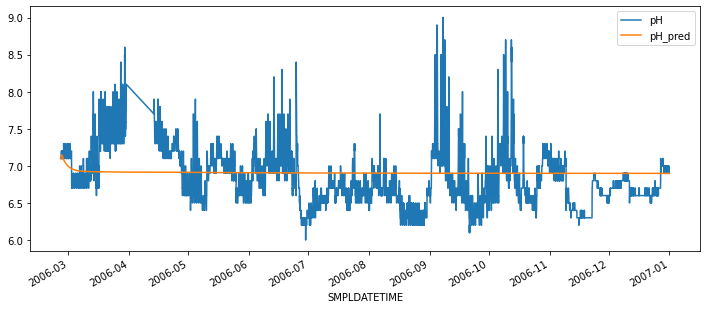

In [46]:
# for pH column
test_vs_pred_pH=pd.concat([test_df.pH,df_predicted.pH_pred],axis=1)
test_vs_pred_pH.plot(figsize=(12,5))

<AxesSubplot:xlabel='SMPLDATETIME'>

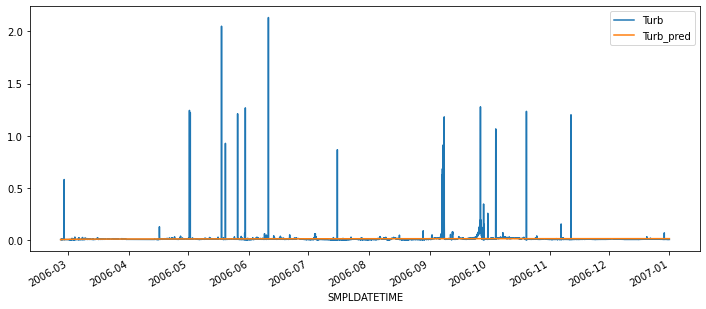

In [47]:
# for Turb column
test_vs_pred_Turb=pd.concat([test_df.Turb,df_predicted.Turb_pred],axis=1)
test_vs_pred_Turb.plot(figsize=(12,5))

#### Checking for RMSE scores of the variables forecasted

In [25]:
cols = test_df.columns
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(predictions)),columns=[cols])
for j in range(0,6):
    for i in range(0, len(predictions)):
        pred.iloc[i][j] = predictions[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', sqrt(mean_squared_error(pred[i], test_df[i])))

rmse value for WQI is :  11.428185508588768
rmse value for Temp is :  8.884577521135313
rmse value for DO_pct is :  25.96901879566808
rmse value for Depth is :  0.13934558570083264
rmse value for pH is :  0.3820298144185135
rmse value for Turb is :  0.048048926174874905


In [26]:
# Checking the mean of all forecasted variables 
test_df.mean()

WQI       27.948689
Temp      18.205654
DO_pct    78.359886
Depth      0.310040
pH         6.825588
Turb       0.016087
dtype: float64

#### we can see that RMSE scores are less than mean of the forecasted variables hence we can say model is performing good.
#### For better forecasting we can use deeplearning models like LSTM and Transformers in Multivariate analysis.
## END